# Survival impact of InstaPrism cell-type fractions in Schildkraut HGSOC: Sensitivity Analysis

To confirm that the adipocyte association was not confounded by other TME components, we performed a sensitivity analysis including adipocyte proportions together with immune and stromal fractions in the same models, excluding epithelial content to reduce collinearity (Supplemental Fig. 4). 

**Results** 

The results were consistent with the primary analysis: adipocyte abundance remained significantly associated with worse survival in both the main (HR = 1.42, 95% CI 1.17-1.71, p = 0.0003) and restricted (HR = 1.40, 95% CI 1.05-1.86, p = 0.021) models, while immune abundance retained a significant protective association in the main model (HR = 0.80, 95% CI 0.67-0.96, p = 0.014), with a similar magnitude in the restricted model (HR = 0.78, 95% CI 0.60-1.01, p = 0.059) (Supplemental Fig. 4). Stromal content again showed no association with survival. Both models exhibited borderline proportional-hazards violations, so these findings are presented for transparency rather than inference (Supplemental Fig. 4).

In [1]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
from sklearn.model_selection import ParameterGrid
import numpy as np, pandas as pd
from lifelines.utils import k_fold_cross_validation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid, KFold
import os
from sklearn.preprocessing import StandardScaler
from matplotlib_venn import venn2
import sys
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import LogLocator, LogFormatter

sys.path.insert(1, "../../")
sys.path.insert(1, "../")

import src.hp as hp

pd.set_option("display.max_rows", 100)
plt.style.use("default")

np.random.seed(88)

In [2]:
complete_case = False
use_interview_time = True

In [3]:
map_stage = True
remove_unknown_stage = True
remove_999_BMI = True
kaplan_meier = True
remove_BMI_treat = False

## Paths

In [4]:
base_path = os.path.dirname(os.getcwd())
meta_path = os.path.join(base_path, "input_data/metadata.xlsx")

### Formatting for below plots, etc.

In [5]:
if complete_case:
    remove_treatment = False
    remove_pts_with_unknowns = True

else:
    remove_treatment = True
    remove_pts_with_unknowns = False

In [6]:
## The order for the plots below
desired_order = [
    "Age",
    "BMI",
    "Race: Black",
    "Residual: < 1cm",
    "Residual: ≥ 1cm",
]
if remove_treatment:
    desired_order.remove("Residual: < 1cm")
    desired_order.remove("Residual: ≥ 1cm")
desired_order

['Age', 'BMI', 'Race: Black']

In [7]:
# continuous covariates to keep “as is”
cont_cols = ["Age", "BMI"]

## Load InstaPrism cell-fraction tables (processed) and metadata

Proportions

In [8]:
props = pd.read_csv(
    os.path.join(base_path, "input_data/proportions_sch.csv"), index_col=0
)
props

,SampleID,Plasma cells,B cells,Endothelial cells,T cells,Monocytes,Fibroblasts,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset,suid,ID
0,18341X10,4.919765e-49,0.052767,0.029870,1.833554e-26,1.727071e-60,7.074672e-105,8.375315e-10,0.746341,1.257780e-139,3.590420e-30,2.867046e-78,1.185148e-02,1.538137e-57,0.0,0.159171,SchildkrautB,18341X10,45369
1,18341X12,9.351753e-92,0.027159,0.011666,5.972580e-66,2.258210e-157,8.180384e-107,8.135649e-61,0.848153,3.276474e-210,2.054386e-103,1.247009e-85,2.337775e-128,1.452291e-115,0.0,0.113022,SchildkrautB,18341X12,47261
2,18341X13,6.998799e-32,0.014663,0.041547,1.004614e-23,3.232466e-34,1.225464e-02,9.550579e-19,0.819028,1.104356e-115,3.157063e-69,7.123720e-41,2.994756e-02,1.850941e-63,0.0,0.082561,SchildkrautB,18341X13,47791
3,18341X14,2.410384e-97,0.162711,0.022343,2.056824e-52,5.485488e-33,2.751866e-120,7.904174e-39,0.642545,4.774011e-154,1.326676e-75,2.334007e-77,1.516542e-02,1.488048e-80,0.0,0.157235,SchildkrautB,18341X14,47916
4,18341X15,3.439318e-76,0.050581,0.055021,5.687981e-28,5.314872e-52,8.961526e-02,2.919113e-22,0.649017,7.625379e-122,1.873123e-52,3.487465e-81,1.419715e-02,4.216693e-41,0.0,0.141568,SchildkrautB,18341X15,48002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,20160X95,1.442627e-108,0.136578,0.014420,3.410104e-30,3.267116e-82,7.666630e-23,1.501224e-35,0.710289,6.509988e-151,4.903142e-78,8.571710e-105,3.473745e-03,5.671299e-79,0.0,0.135240,SchildkrautW,20160X95,47786
584,20160X96,1.359916e-92,0.190881,0.017396,5.383974e-33,2.734703e-86,1.156925e-02,1.945285e-24,0.592805,1.063562e-147,5.374615e-82,8.551669e-96,1.270617e-02,4.370517e-04,0.0,0.174205,SchildkrautW,20160X96,47903
585,20160X97,7.862780e-79,0.102850,0.053137,8.610293e-03,1.076987e-46,4.237821e-02,1.467756e-05,0.656171,3.397744e-114,5.089409e-39,1.625064e-79,2.253584e-02,9.865474e-05,0.0,0.114204,SchildkrautW,20160X97,47926
586,20160X98,1.245316e-60,0.127050,0.034344,1.345753e-16,5.846372e-04,2.787547e-02,2.169830e-04,0.673204,4.422809e-95,4.998254e-48,3.881728e-35,5.796692e-04,4.236351e-47,0.0,0.136146,SchildkrautW,20160X98,47937


Merge cell groups, multiply by 10

In [9]:
props["Immune"] = (
    props[
        [
            "B cells",
            "Mast cells",
            "T cells",
            "Monocytes",
            "Plasma cells",
            "NK cells",
            "DC",
            "pDC",
            "Macrophages",
            "ILC",
        ]
    ].sum(axis=1)
    * 10
)
props["Epithelial"] = props["Epithelial cells"] * 10
props["Adipocytes"] = props["Adipocytes"] * 10
props["Stromal"] = props[["Fibroblasts", "Endothelial cells"]].sum(axis=1) * 10
props = props[["Stromal", "Immune", "Adipocytes", "SampleID", "Dataset", "ID"]]

props

,Stromal,Immune,Adipocytes,SampleID,Dataset,ID
0,0.298699,0.646185,1.591710,18341X10,SchildkrautB,45369
1,0.116663,0.271593,1.130216,18341X12,SchildkrautB,47261
2,0.538013,0.446102,0.825608,18341X13,SchildkrautB,47791
3,0.223432,1.778767,1.572353,18341X14,SchildkrautB,47916
4,1.446367,0.647785,1.415675,18341X15,SchildkrautB,48002
...,...,...,...,...,...,...
583,0.144201,1.400515,1.352398,20160X95,SchildkrautW,47786
584,0.289654,2.040245,1.742051,20160X96,SchildkrautW,47903
585,0.955156,1.341094,1.142044,20160X97,SchildkrautW,47926
586,0.622194,1.284310,1.361460,20160X98,SchildkrautW,47937


## Merge, encode categorical covariates

### Build the analysis table  (clinical + cell fractions)


In [10]:
renaming = hp.get_variable_renaming()
renaming.pop("tissue", None)

'Tissue'

Metadata

In [11]:
## Importing and renaming metadata

# ------------------------------ clinical columns -----------------
meta_full = (
    pd.read_excel(meta_path, sheet_name=0)
    .rename(columns=str.strip)
    .rename(columns=renaming)
)

meta_full = meta_full[renaming.values()]

meta_full["Stage"] = pd.to_numeric(meta_full["Stage"], errors="coerce")

meta_full["Event"] = meta_full["Event"].astype(int)
meta_full["Time-Years"] = meta_full["Time_Yrs"]
meta_full.pop("Time_Yrs")
meta_full["Time-Days"] = meta_full["Time-Years"] * 365.22

## Removing patients that received adj. therapy in one case
if complete_case:
    to_rm_adjtx = meta_full[meta_full["AdjTx"] == 2]["ID"].unique().tolist()
    meta_full = meta_full[~meta_full["ID"].isin(to_rm_adjtx)]
    props = props[~props["ID"].isin(to_rm_adjtx)]

meta_full

,ID,Age,Event,Stage,Race,Debulk,Hispanic,BMI,NeoTx,AdjTx,Residual,Time-Years,Time-Days
0,40143,63,1,3,1,2.0,2,23.218229,2.0,1.0,4.0,8.739220,3191.737824
1,41377,54,1,3,1,2.0,2,17.428942,2.0,NaN,3.0,1.180014,430.964599
2,41387,55,1,3,2,1.0,2,45.470350,2.0,1.0,2.0,11.983573,4376.640495
3,41391,60,1,3,1,2.0,2,31.340800,2.0,NaN,3.0,4.993840,1823.850185
4,41435,59,1,3,1,NaN,2,23.922658,NaN,NaN,NaN,4.057495,1481.878275
...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0,3,2,NaN,2,28.349557,NaN,NaN,NaN,9.702186,3543.432295
584,320012,66,0,3,2,2.0,2,37.677475,2.0,1.0,4.0,11.767760,4297.821147
585,320025,60,1,3,2,2.0,2,38.740537,2.0,1.0,3.0,6.827869,2493.674262
586,320043,57,1,3,2,2.0,2,19.854802,2.0,1.0,4.0,1.553425,567.341754


In [12]:
if use_interview_time:
    # ------------------------------ clinical columns -----------------
    meta_new_path = os.path.join(base_path, "input_data/AACES_clinical.csv")
    meta_new = pd.read_csv(meta_new_path)
    meta_new["ID"] = meta_new.suid
    meta_new.index = meta_new.ID

    intersect = np.intersect1d(meta_full["ID"].unique(), meta_new.index.unique())
    meta_new = meta_new.loc[intersect]
    old_idx = meta_full.index
    meta_full.index = meta_full.ID

    meta_full["Time-Days"] = meta_new["days_int_to_event"]
    meta_full["Time-Years"] = meta_new["days_int_to_event"] / 365.22
    meta_full["Event"] = meta_new["vital_status_fin"].astype(float)

    meta_full.index = old_idx

In [13]:
# Mapping unknown residual treatment size to >=1cm
meta_full["Residual"] = meta_full["Residual"].replace(
    4.0, 3.0
)  ## Making the residual disaease unknow size

if remove_unknown_stage:
    first = meta_full.shape[0]
    meta_full = meta_full[meta_full["Stage"] != 9]
    print("Removed for unknown stage: ", first - meta_full.shape[0])

if remove_999_BMI:
    first = meta_full.shape[0]
    meta_full = meta_full[meta_full["BMI"] != 999]
    print("Removed for BMI 999: ", first - meta_full.shape[0])

# In no case we'd use Hispanic variable:
meta_full.drop(columns=["Hispanic"], inplace=True)

# We are removing debulking treatment that includes CA125.
meta_full.drop(columns=["Debulk"], inplace=True)

meta_full.drop(columns=["NeoTx"], inplace=True)

meta_full

Removed for unknown stage:  9
Removed for BMI 999:  13


,ID,Age,Event,Stage,Race,BMI,AdjTx,Residual,Time-Years,Time-Days
0,40143,63,1.0,3,1,23.218229,1.0,3.0,8.362083,3054.0
1,41377,54,1.0,3,1,17.428942,NaN,3.0,0.821423,300.0
2,41387,55,1.0,3,2,45.470350,1.0,2.0,11.576584,4228.0
3,41391,60,1.0,3,1,31.340800,NaN,3.0,4.632824,1692.0
4,41435,59,1.0,3,1,23.922658,NaN,NaN,2.817480,1029.0
...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0.0,3,2,28.349557,NaN,NaN,8.460654,3090.0
584,320012,66,0.0,3,2,37.677475,1.0,3.0,11.294562,4125.0
585,320025,60,1.0,3,2,38.740537,1.0,3.0,6.429002,2348.0
586,320043,57,1.0,3,2,19.854802,1.0,3.0,1.193801,436.0


In [14]:
# If we remove treatment we only keep Race and Stage of the categoricals.
if remove_treatment:
    cat_cols = ["Stage", "Race"]
    meta_full[cat_cols] = meta_full[cat_cols].astype("category")
    meta_full.columns
else:
    cat_cols = ["Stage", "Race", "Residual", "AdjTx"]
    meta_full[cat_cols] = meta_full[cat_cols].astype("category")
    meta_full.columns

if complete_case:
    to_rm_adjtx = meta_full[meta_full["AdjTx"] == 2]["ID"].unique().tolist()
    meta_full = meta_full[~meta_full["ID"].isin(to_rm_adjtx)]
    props = props[~props["ID"].isin(to_rm_adjtx)]

meta_full

,ID,Age,Event,Stage,Race,BMI,AdjTx,Residual,Time-Years,Time-Days
0,40143,63,1.0,3,1,23.218229,1.0,3.0,8.362083,3054.0
1,41377,54,1.0,3,1,17.428942,NaN,3.0,0.821423,300.0
2,41387,55,1.0,3,2,45.470350,1.0,2.0,11.576584,4228.0
3,41391,60,1.0,3,1,31.340800,NaN,3.0,4.632824,1692.0
4,41435,59,1.0,3,1,23.922658,NaN,NaN,2.817480,1029.0
...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0.0,3,2,28.349557,NaN,NaN,8.460654,3090.0
584,320012,66,0.0,3,2,37.677475,1.0,3.0,11.294562,4125.0
585,320025,60,1.0,3,2,38.740537,1.0,3.0,6.429002,2348.0
586,320043,57,1.0,3,2,19.854802,1.0,3.0,1.193801,436.0


In [15]:
# ------------------------------ merge meta + props ----------------------------
# every SampleID maps to a unique suid)
analysis = props.merge(meta_full, on="ID", how="inner")

print(f"Using: {analysis.shape[0]} rows, {analysis['ID'].nunique()} patients")

analysis

Using: 566 rows, 566 patients


,Stromal,Immune,Adipocytes,SampleID,Dataset,ID,Age,Event,Stage,Race,BMI,AdjTx,Residual,Time-Years,Time-Days
0,0.298699,0.646185,1.591710,18341X10,SchildkrautB,45369,53,1.0,3,2,31.110562,1.0,3.0,1.256777,459.0
1,0.116663,0.271593,1.130216,18341X12,SchildkrautB,47261,57,1.0,3,2,29.448927,NaN,NaN,4.531515,1655.0
2,0.538013,0.446102,0.825608,18341X13,SchildkrautB,47791,45,1.0,3,2,40.981420,NaN,NaN,4.224851,1543.0
3,0.223432,1.778767,1.572353,18341X14,SchildkrautB,47916,68,1.0,4,2,28.928061,NaN,NaN,1.766059,645.0
4,1.446367,0.647785,1.415675,18341X15,SchildkrautB,48002,44,1.0,3,2,24.991295,1.0,2.0,1.130825,413.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,0.144201,1.400515,1.352398,20160X95,SchildkrautW,47786,68,1.0,3,1,31.538819,NaN,NaN,1.785225,652.0
562,0.289654,2.040245,1.742051,20160X96,SchildkrautW,47903,45,1.0,3,1,20.410354,NaN,NaN,2.540934,928.0
563,0.955156,1.341094,1.142044,20160X97,SchildkrautW,47926,52,0.0,3,1,34.458370,NaN,NaN,14.112042,5154.0
564,0.622194,1.284310,1.361460,20160X98,SchildkrautW,47937,43,1.0,3,1,20.156950,1.0,2.0,2.724385,995.0


In [16]:
## Mapping the stage variable for stratification
if map_stage:
    stage_map = {1: 1, 2: 1, 3: 2, 4: 2}
    analysis["Stage"] = analysis.Stage.map(stage_map)

if remove_pts_with_unknowns:
    print("Going from: ", analysis.shape)
    analysis = analysis.dropna(subset=["Residual", "AdjTx"])
    print("To: ", analysis.shape)

analysis

,Stromal,Immune,Adipocytes,SampleID,Dataset,ID,Age,Event,Stage,Race,BMI,AdjTx,Residual,Time-Years,Time-Days
0,0.298699,0.646185,1.591710,18341X10,SchildkrautB,45369,53,1.0,2,2,31.110562,1.0,3.0,1.256777,459.0
1,0.116663,0.271593,1.130216,18341X12,SchildkrautB,47261,57,1.0,2,2,29.448927,NaN,NaN,4.531515,1655.0
2,0.538013,0.446102,0.825608,18341X13,SchildkrautB,47791,45,1.0,2,2,40.981420,NaN,NaN,4.224851,1543.0
3,0.223432,1.778767,1.572353,18341X14,SchildkrautB,47916,68,1.0,2,2,28.928061,NaN,NaN,1.766059,645.0
4,1.446367,0.647785,1.415675,18341X15,SchildkrautB,48002,44,1.0,2,2,24.991295,1.0,2.0,1.130825,413.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,0.144201,1.400515,1.352398,20160X95,SchildkrautW,47786,68,1.0,2,1,31.538819,NaN,NaN,1.785225,652.0
562,0.289654,2.040245,1.742051,20160X96,SchildkrautW,47903,45,1.0,2,1,20.410354,NaN,NaN,2.540934,928.0
563,0.955156,1.341094,1.142044,20160X97,SchildkrautW,47926,52,0.0,2,1,34.458370,NaN,NaN,14.112042,5154.0
564,0.622194,1.284310,1.361460,20160X98,SchildkrautW,47937,43,1.0,2,1,20.156950,1.0,2.0,2.724385,995.0


In [17]:
for col in analysis:
    print(analysis[col].value_counts(dropna=False))

Stromal
0.298699    1
0.309848    1
3.079126    1
0.710995    1
0.046398    1
           ..
0.226319    1
1.039749    1
0.191476    1
1.912993    1
0.931990    1
Name: count, Length: 566, dtype: int64
Immune
0.646185    1
1.285318    1
0.414924    1
0.710508    1
0.883100    1
           ..
0.827706    1
1.068618    1
1.198316    1
2.012275    1
0.606426    1
Name: count, Length: 566, dtype: int64
Adipocytes
1.591710    1
0.624160    1
2.321141    1
1.261022    1
0.897740    1
           ..
0.867091    1
1.215493    1
1.121835    1
1.877957    1
1.484585    1
Name: count, Length: 566, dtype: int64
SampleID
18341X10     1
20160X191    1
20160X186    1
20160X187    1
20160X188    1
            ..
19291X280    1
19291X279    1
19291X278    1
19291X277    1
20160X99     1
Name: count, Length: 566, dtype: int64
Dataset
SchildkrautW    303
SchildkrautB    263
Name: count, dtype: int64
ID
45369     1
43225     1
42710     1
42714     1
42912     1
         ..
190201    1
190197    1
190191   

In [18]:
if remove_treatment:
    if remove_BMI_treat:
        cols = ["Age", "Event", "Time-Years", "Time-Days", "Stage", "Residual", "AdjTx"]
    else:
        cols = [
            "Age",
            "Event",
            "Time-Years",
            "BMI",
            "Time-Days",
            "Stage",
            "Residual",
            "AdjTx",
        ]

    cat_cols = ["Race"]
    # Get dummys for categorical columns with more than 2 cats (NaN counts as category)
    dummies = pd.get_dummies(
        analysis, columns=cat_cols, drop_first=True, prefix_sep="_"
    )
    dummies.drop(columns=props.columns, inplace=True)  # remove original proportions
    dummies.drop(columns=cols, inplace=True)  # remove original proportions
    dummies

else:
    cols = ["Age", "Event", "Time-Years", "BMI", "Time-Days", "Stage"]

    cat_cols = ["Residual", "AdjTx", "Race"]
    # Get dummys for categorical columns with more than 2 cats (NaN counts as category)
    dummies = pd.get_dummies(
        analysis, columns=cat_cols, drop_first=True, prefix_sep="_"
    )
    dummies.drop(columns=props.columns, inplace=True)  # remove original proportions
    dummies.drop(columns=cols, inplace=True)  # remove original proportions
dummies

,Race_2
0,True
1,True
2,True
3,True
4,True
...,...
561,False
562,False
563,False
564,False


In [19]:
for col in dummies:
    print(dummies[col].value_counts(dropna=False))

Race_2
False    303
True     263
Name: count, dtype: int64


In [20]:
# Put together the analysis DataFrame
# (keep the original categorical columns for later use)
analysis_enc = pd.concat([analysis, dummies], axis=1)  # Columns that go into the model
cell_cols = props.columns.difference(["SampleID", "Dataset", "ID"])  # fractions
covars = cont_cols + list(dummies.columns) + list(cell_cols) + ["Stage"]

covars

['Age', 'BMI', 'Race_2', 'Adipocytes', 'Immune', 'Stromal', 'Stage']

In [21]:
cox_df = analysis_enc[["Time-Days", "Event"] + covars].copy()

# and let's make names more interpretable:
if "AdjTx_2.0" in cox_df.columns:
    cox_df.rename(columns={"AdjTx_2.0": "No Adj Tx."}, inplace=True)
if "Race_2" in cox_df.columns:
    cox_df.rename(columns={"Race_2": "Race: Black"}, inplace=True)
if "Residual_4.0" in cox_df.columns:
    cox_df.rename(columns={"Residual_4.0": "Residual: Unknown size"}, inplace=True)
    cox_df.rename(columns={"Residual_3.0": "Residual: ≥ 1cm"}, inplace=True)
    cox_df.rename(columns={"Residual_2.0": "Residual: < 1cm"}, inplace=True)

In [22]:
print("Design matrix:", cox_df.shape)
print("Design matrix columns:", cox_df.columns)
cox_df

Design matrix: (566, 9)
Design matrix columns: Index(['Time-Days', 'Event', 'Age', 'BMI', 'Race: Black', 'Adipocytes',
       'Immune', 'Stromal', 'Stage'],
      dtype='object')


,Time-Days,Event,Age,BMI,Race: Black,Adipocytes,Immune,Stromal,Stage
0,459.0,1.0,53,31.110562,True,1.591710,0.646185,0.298699,2
1,1655.0,1.0,57,29.448927,True,1.130216,0.271593,0.116663,2
2,1543.0,1.0,45,40.981420,True,0.825608,0.446102,0.538013,2
3,645.0,1.0,68,28.928061,True,1.572353,1.778767,0.223432,2
4,413.0,1.0,44,24.991295,True,1.415675,0.647785,1.446367,2
...,...,...,...,...,...,...,...,...,...
561,652.0,1.0,68,31.538819,False,1.352398,1.400515,0.144201,2
562,928.0,1.0,45,20.410354,False,1.742051,2.040245,0.289654,2
563,5154.0,0.0,52,34.458370,False,1.142044,1.341094,0.955156,2
564,995.0,1.0,43,20.156950,False,1.361460,1.284310,0.622194,2


Iteration 1: norm_delta = 2.63e-01, step_size = 0.9500, log_lik = -2433.79148, newton_decrement = 1.43e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.66e-02, step_size = 0.9500, log_lik = -2420.24554, newton_decrement = 7.19e-02, seconds_since_start = 0.0
Iteration 3: norm_delta = 9.61e-04, step_size = 0.9500, log_lik = -2420.17347, newton_decrement = 2.40e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 4.72e-07, step_size = 1.0000, log_lik = -2420.17323, newton_decrement = 6.19e-11, seconds_since_start = 0.0
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 566 total observations, 110 right-censored observations>
             duration col = 'Time-Days'
                event col = 'Event'
                   strata = Stage
      baseline estimation = breslow
   number of observations = 566
number of events observed = 456
   partial log-likelihood = -2420.17
         time fit was run = 2026-01-06 22:26:38 UTC

---
             coef exp(coef)     z      p
covariate                               
Age          0.01      1.01  2.11   0.03
BMI          0.01      1.01  1.11   0.27
Race: Black  0.03      1.03  0.25   0.80
Adipocytes   0.35      1.42  3.60 <0.005
Immune      -0.22      0.80 -2.45   0.01
Stromal      0.04      1.04  0.78   0.44
---
Concordance = 0.57
Partial AIC = 4852.35
log-likelihood ratio test = 27.24 on 6 df
-log2(p) of ll-ratio test = 12.90

<Axes: xlabel='log(HR) (95% CI)'>

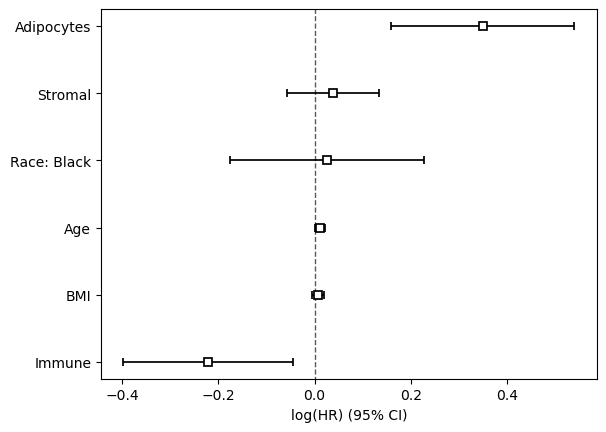

In [23]:
# ------------------------------ fit penalised CoxPH ------------------------------
cph = CoxPHFitter()

cph.fit(
    cox_df,
    show_progress=True,
    strata="Stage",
    duration_col="Time-Days",
    event_col="Event",
)

cph.print_summary(columns=["coef", "exp(coef)", "p", "z"])

cph.plot()

In [24]:
if complete_case:

    title_for_plot = f"All Cell Groups: Restricted Model (n={str(analysis.shape[0])})"

else:

    title_for_plot = f"All Cell Groups: Main Model (n={str(analysis.shape[0])})"

In [25]:
# Full table
dataframe_to_save = cph.summary.copy()
title = "Main Model" if not complete_case else "Restricted Model"
dataframe_to_save["model"] = title
save_path = (
    f"{os.getcwd()}/../results/coxph_summary_allcelltypes_{title.replace(' ','_')}.csv"
)
dataframe_to_save.to_csv(save_path)

In [26]:
title_to_open = "Main Model" if complete_case else "Restricted Model"
save_path = f"{os.getcwd()}/../results/coxph_summary_allcelltypes_{title_to_open.replace(' ','_')}.csv"
other_model = pd.read_csv(save_path, index_col=0)
results = pd.concat([other_model, dataframe_to_save])
results

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p),model
covariate,,,,,,,,,,,,
Age,0.003821,1.003828,0.007664,-0.011200,0.018842,0.988862,1.019020,0.0,0.498519,0.618118,0.694046,Restricted Model
BMI,0.002410,1.002413,0.009842,-0.016880,0.021701,0.983261,1.021938,0.0,0.244896,0.806537,0.310188,Restricted Model
Residual_2.0,0.427551,1.533497,0.189796,0.055558,0.799544,1.057130,2.224525,0.0,2.252688,0.024279,5.364156,Restricted Model
Residual_3.0,0.845778,2.329791,0.189781,0.473815,1.217742,1.606110,3.379548,0.0,4.456606,0.000008,16.873816,Restricted Model
Race: Black,0.134187,1.143606,0.165784,-0.190744,0.459118,0.826344,1.582677,0.0,0.809405,0.418282,1.257452,Restricted Model
Adipocytes,0.334609,1.397394,0.145479,0.049476,0.619742,1.050720,1.858448,0.0,2.300056,0.021445,5.543211,Restricted Model
Immune,-0.254530,0.775281,0.134842,-0.518815,0.009756,0.595225,1.009804,0.0,-1.887609,0.059078,4.081225,Restricted Model
Stromal,0.051545,1.052897,0.073678,-0.092860,0.195951,0.911321,1.216467,0.0,0.699605,0.484174,1.046403,Restricted Model
Age,0.010626,1.010683,0.005026,0.000776,0.020477,1.000776,1.020688,0.0,2.114393,0.034482,4.858024,Main Model


In [27]:
summ_cop = cph.summary.copy()
summ = results.loc[["Adipocytes", "Immune", "Stromal"]].copy()
col = summ.index + ":\n" + summ.model
summ.index = col.values
summ

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p),model
Adipocytes:\nRestricted Model,0.334609,1.397394,0.145479,0.049476,0.619742,1.050720,1.858448,0.0,2.300056,0.021445,5.543211,Restricted Model
Adipocytes:\nMain Model,0.349207,1.417943,0.096924,0.159239,0.539175,1.172619,1.714592,0.0,3.602891,0.000315,11.633745,Main Model
Immune:\nRestricted Model,-0.254530,0.775281,0.134842,-0.518815,0.009756,0.595225,1.009804,0.0,-1.887609,0.059078,4.081225,Restricted Model
Immune:\nMain Model,-0.220655,0.801993,0.090092,-0.397232,-0.044079,0.672178,0.956878,0.0,-2.449232,0.014316,6.126215,Main Model
Stromal:\nRestricted Model,0.051545,1.052897,0.073678,-0.092860,0.195951,0.911321,1.216467,0.0,0.699605,0.484174,1.046403,Restricted Model
Stromal:\nMain Model,0.038252,1.038993,0.049127,-0.058035,0.134539,0.943617,1.144009,0.0,0.778641,0.436191,1.196968,Main Model


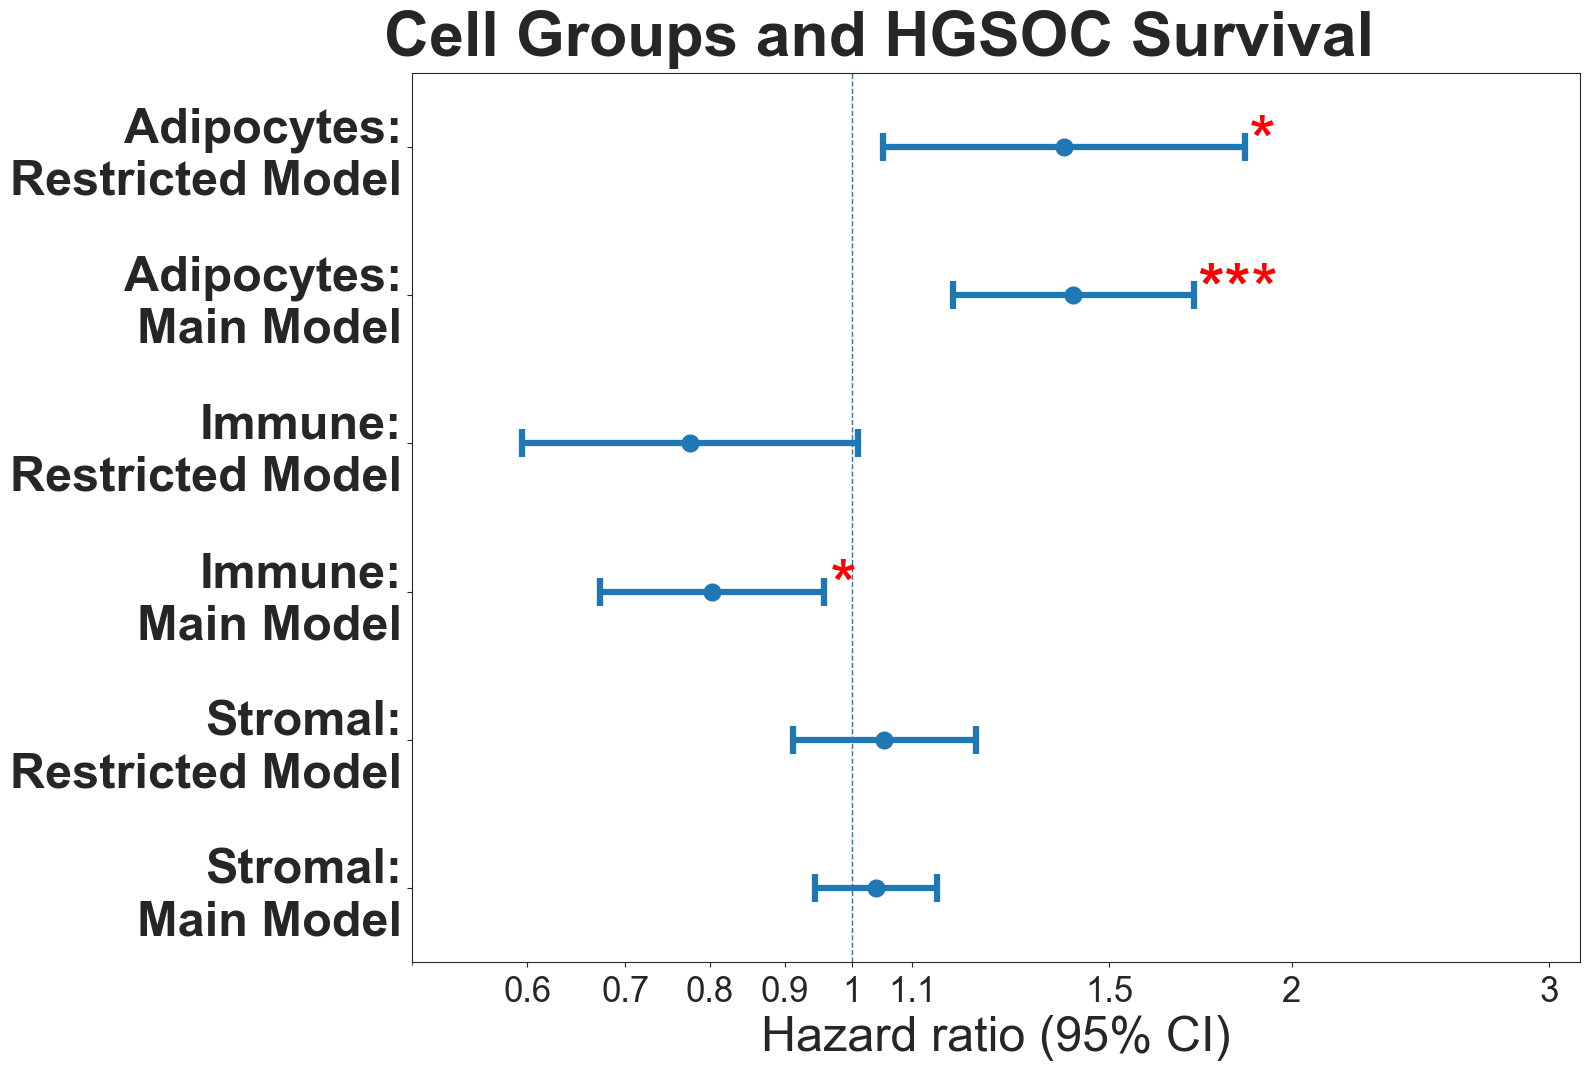

In [28]:
# ------------------------------------------------------------------
# 1. Pull the numbers we need on the *log(HR)* scale (Cox β)
# ------------------------------------------------------------------
sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})

# Locate the 95% CI columns, version-agnostic
ci_lower_col = [c for c in summ.columns if c.startswith("coef lower")][0]
ci_upper_col = [c for c in summ.columns if c.startswith("coef upper")][0]

# Work directly on the log scale (β = log(HR))
summ["HR"] = np.exp(summ["coef"])
summ["lower95"] = np.exp(summ[ci_lower_col])
summ["upper95"] = np.exp(summ[ci_upper_col])

# ------------------------------------------------------------------
# 2. Plot on a linear x-axis whose units are log(HR)
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(16, 1.8 * len(summ)))
ypos = np.arange(len(summ))

ax.errorbar(
    x=summ["HR"],
    y=ypos,
    xerr=[summ["HR"] - summ["lower95"], summ["upper95"] - summ["HR"]],
    fmt="o",
    capsize=10,
    linewidth=4.5,
    elinewidth=4.5,
    capthick=4.5,
    markersize=12,
)

# Stars for p-values (unchanged; positioned just to the right of the CI)
for i, p in enumerate(summ["p"]):
    if p < 0.05:
        ax.text(
            summ["upper95"].iloc[i] + 0.01,
            ypos[i],
            "*",
            va="center",
            fontsize=50,
            color="red",
        )
    if p < 0.005:
        ax.text(
            summ["upper95"].iloc[i] + 0.01,
            ypos[i],
            "**",
            va="center",
            fontsize=50,
            color="red",
        )
    if p < 0.0005:
        ax.text(
            summ["upper95"].iloc[i] + 0.01,
            ypos[i],
            "***",
            va="center",
            fontsize=50,
            color="red",
        )
padding = 0.5
ax.set_ylim(-padding, len(summ) - 1 + padding)
ax.set_xscale("log")
ax.set_yticks(ypos)
ax.tick_params(axis="x", labelsize=25)
ax.set_yticklabels(summ.index, fontsize=35, fontweight="bold")
ax.set_ylabel("", fontsize=35)
ax.set_xlabel("Hazard ratio (95% CI)", fontsize=35)
ax.set_title(
    f"Cell Groups and HGSOC Survival", fontsize=45, fontweight="bold", y=1.01, x=0.4
)

from matplotlib.ticker import FixedLocator, FuncFormatter, LogLocator, NullFormatter

# 1) Fixed limits for all figures
ax.set_xscale("log")
ax.set_xlim(0.5, 3.15)

# 2) Fixed major tick *values* (same everywhere)
fixed_ticks = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.5, 2.0, 3.0]
ax.xaxis.set_major_locator(FixedLocator(fixed_ticks))


# 3) Plain decimal labels (no 10^x, no 1e-01), tidy zeros
def plain_fmt(x, pos):
    if x < 1:
        s = f"{x:.2f}"
    elif x < 10:
        s = f"{x:.1f}"
    else:
        s = f"{x:g}"
    return s.rstrip("0").rstrip(".")


ax.xaxis.set_major_formatter(FuncFormatter(plain_fmt))

# 4) Optional: minor tick marks only (no labels), for log “feel”
ax.xaxis.set_minor_locator(LogLocator(base=10, subs=(2, 3, 4, 5, 6, 7, 8, 9)))
ax.xaxis.set_minor_formatter(NullFormatter())

# 5) Styling (adjust size if they feel tight)
ax.tick_params(axis="x", which="major", labelsize=22, pad=6)

# 4) styling
ax.tick_params(axis="x", which="major", labelsize=25)
ax.axvline(1, ls="--", lw=1)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

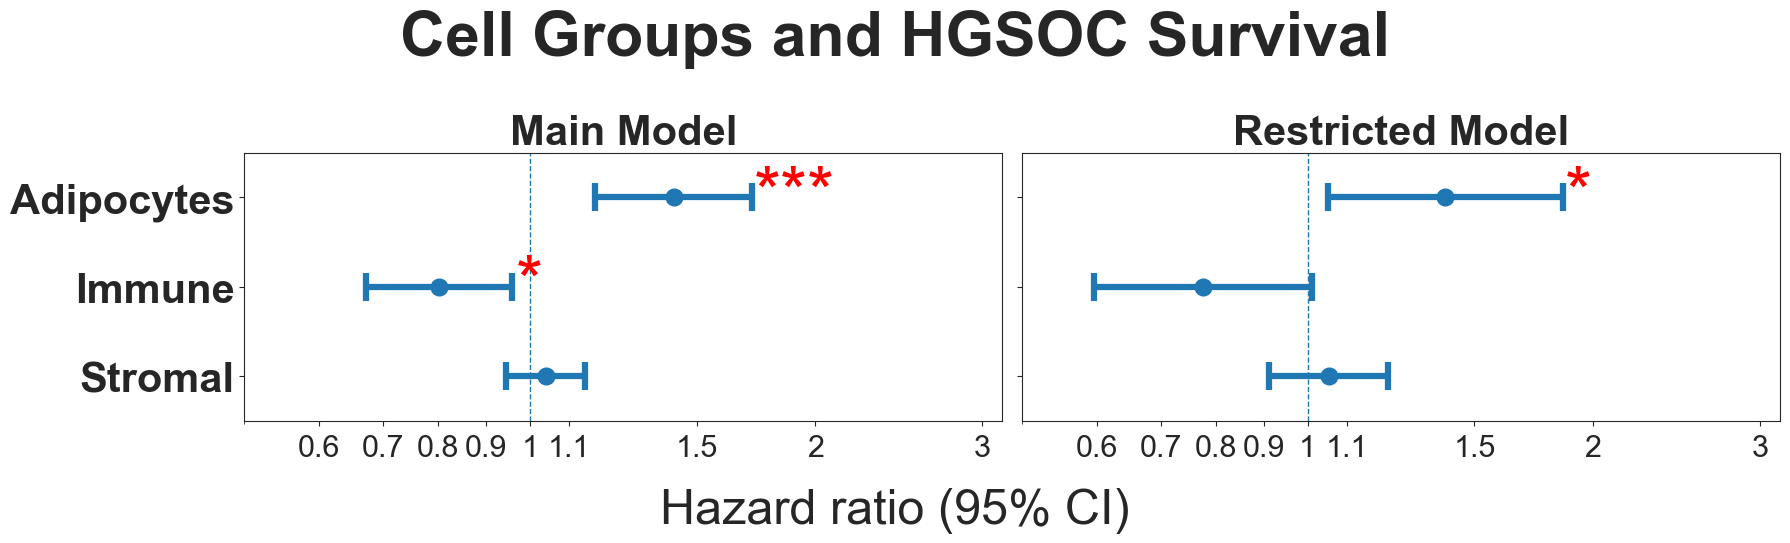

In [29]:
summ = summ.copy()

# Example index: "Adipocytes: Restricted Model"
summ["Model"] = np.where(
    summ.index.str.contains("Restricted", case=False), "Restricted Model", "Main Model"
)
summ["CellGroup"] = summ.index.str.split(":").str[0].str.strip()

model_order = ["Main Model", "Restricted Model"]
group_order = ["Adipocytes", "Immune", "Stromal"]  # adjust if you have more / fewer

# ------------------------------------------------------------
# 2. Forest plots: one per model, same x-axis
# ------------------------------------------------------------
fig, axes = plt.subplots(
    1, 2, sharex=True, sharey=True, figsize=(18, 1.8 * len(group_order))
)

for ax, model in zip(axes, model_order):
    sub = (
        summ[summ["Model"] == model]
        .set_index("CellGroup")
        .loc[group_order]  # enforce consistent order
    )

    ypos = np.arange(len(sub))

    ax.errorbar(
        x=sub["HR"],
        y=ypos,
        xerr=[sub["HR"] - sub["lower95"], sub["upper95"] - sub["HR"]],
        fmt="o",
        capsize=10,
        linewidth=4.5,
        elinewidth=4.5,
        capthick=4.5,
        markersize=12,
    )

    # p-value stars
    for i, (p, x_right, y) in enumerate(zip(sub["p"], sub["upper95"], ypos)):
        if p < 0.0005:
            star = "***"
        elif p < 0.005:
            star = "**"
        elif p < 0.05:
            star = "*"
        else:
            star = ""

        if star:
            ax.text(
                x_right + 0.01,
                y,
                star,
                va="center",
                fontsize=50,
                color="red",
            )

    # padding and y settings
    padding = 0.5
    ax.set_ylim(-padding, len(sub) - 1 + padding)
    ax.invert_yaxis()

    # x-axis: log scale and fixed ticks
    ax.set_xscale("log")
    ax.set_xlim(0.5, 3.15)

    fixed_ticks = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.5, 2.0, 3.0]
    ax.xaxis.set_major_locator(FixedLocator(fixed_ticks))

    def plain_fmt(x, pos):
        if x < 1:
            s = f"{x:.2f}"
        elif x < 10:
            s = f"{x:.1f}"
        else:
            s = f"{x:g}"
        return s.rstrip("0").rstrip(".")

    ax.xaxis.set_major_formatter(FuncFormatter(plain_fmt))
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs=(2, 3, 4, 5, 6, 7, 8, 9)))
    ax.xaxis.set_minor_formatter(NullFormatter())
    ax.tick_params(axis="x", which="major", labelsize=22, pad=6)

    # vertical line at HR = 1
    ax.axvline(1, ls="--", lw=1)

    # titles per panel
    ax.set_title(model, fontsize=30, fontweight="bold")

# y-axis labels only on the left plot
axes[0].set_yticks(np.arange(len(group_order)))
axes[0].set_yticklabels(group_order, fontsize=30, fontweight="bold")

# global labels
fig.suptitle("Cell Groups and HGSOC Survival", fontsize=45, fontweight="bold")
fig.supxlabel("Hazard ratio (95% CI)", fontsize=35)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [30]:
desired_order = desired_order + ["Adipocytes", "Immune", "Stromal"]

In [31]:
# Full table
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Age,0.010626,1.010683,0.005026,0.000776,0.020477,1.000776,1.020688,0.0,2.114393,0.034482,4.858024
BMI,0.007375,1.007403,0.006618,-0.005595,0.020346,0.994420,1.020555,0.0,1.114474,0.265076,1.915523
Race: Black,0.025616,1.025947,0.102589,-0.175454,0.226686,0.839076,1.254436,0.0,0.249693,0.802825,0.316843
Adipocytes,0.349207,1.417943,0.096924,0.159239,0.539175,1.172619,1.714592,0.0,3.602891,0.000315,11.633745
Immune,-0.220655,0.801993,0.090092,-0.397232,-0.044079,0.672178,0.956878,0.0,-2.449232,0.014316,6.126215
Stromal,0.038252,1.038993,0.049127,-0.058035,0.134539,0.943617,1.144009,0.0,0.778641,0.436191,1.196968


In [32]:
desired_order = ["Adipocytes", "Immune", "Stromal"]

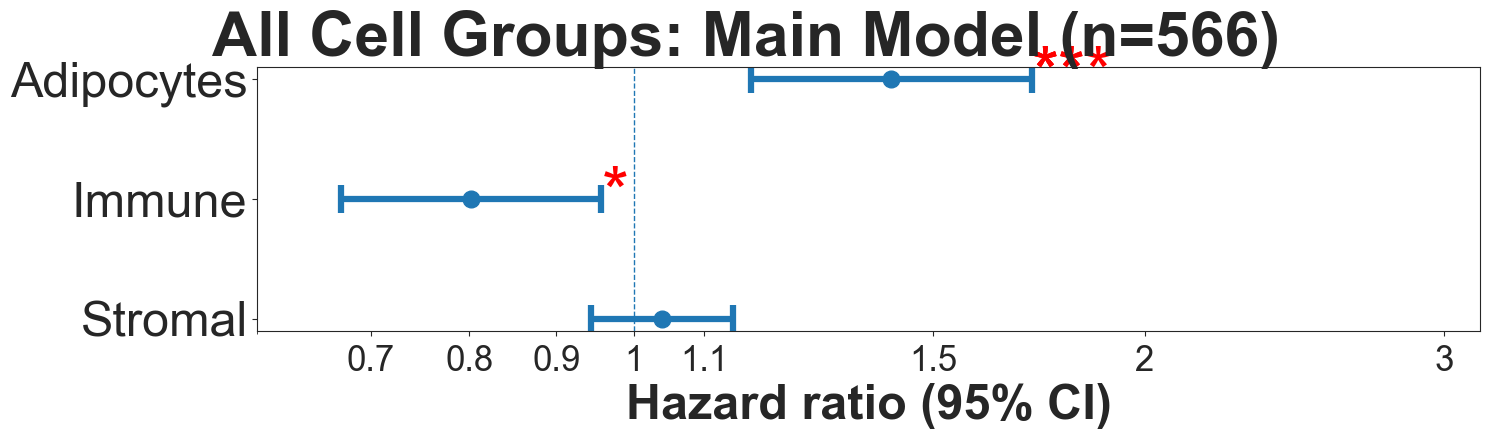

In [33]:
# ------------------------------------------------------------------
# 1. Pull the numbers we need, in a versiofn-agnostic way
# ------------------------------------------------------------------
sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})
summ = cph.summary.loc[desired_order].copy()

# locate the 95 % CI columns no matter what lifelines called them
ci_lower_col = [c for c in summ.columns if c.startswith("coef lower")][0]
ci_upper_col = [c for c in summ.columns if c.startswith("coef upper")][0]

summ["HR"] = np.exp(summ["coef"])
summ["lower95"] = np.exp(summ[ci_lower_col])
summ["upper95"] = np.exp(summ[ci_upper_col])

# ------------------------------------------------------------------
# 2. Plot on a *linear* x-axis
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 1.5 * len(summ)))
ypos = np.arange(len(summ))

ax.errorbar(
    x=summ["HR"],
    y=ypos,
    xerr=[summ["HR"] - summ["lower95"], summ["upper95"] - summ["HR"]],
    fmt="o",
    capsize=10,
    linewidth=4.5,
    elinewidth=4.5,
    capthick=4.5,
    markersize=12,
)
# mark p < 0.05 covariates with a BIG star
for i, p in enumerate(summ["p"]):
    if p < 0.05:
        ax.text(
            summ["upper95"].iloc[i] * 1.001,
            ypos[i],
            "*",
            va="center",
            fontsize=50,
            color="red",
        )
    if p < 0.005:
        ax.text(
            summ["upper95"].iloc[i] * 1.001,
            ypos[i],
            "**",
            va="center",
            fontsize=50,
            color="red",
        )
    if p < 0.0005:
        ax.text(
            summ["upper95"].iloc[i] * 1.001,
            ypos[i],
            "***",
            va="center",
            fontsize=50,
            color="red",
        )
padding = 0.5

from matplotlib.ticker import FixedLocator, FuncFormatter, LogLocator, NullFormatter

# 1) Fixed limits for all figures
ax.set_xscale("log")
ax.set_xlim(0.6, 3.15)

# 2) Fixed major tick *values* (same everywhere)
fixed_ticks = [0.7, 0.8, 0.9, 1.0, 1.1, 1.5, 2.0, 3.0]
ax.xaxis.set_major_locator(FixedLocator(fixed_ticks))


# 3) Plain decimal labels (no 10^x, no 1e-01), tidy zeros
def plain_fmt(x, pos):
    if x < 1:
        s = f"{x:.2f}"
    elif x < 10:
        s = f"{x:.1f}"
    else:
        s = f"{x:g}"
    return s.rstrip("0").rstrip(".")


ax.xaxis.set_major_formatter(FuncFormatter(plain_fmt))

# 4) Optional: minor tick marks only (no labels), for log “feel”
ax.xaxis.set_minor_locator(LogLocator(base=10, subs=(2, 3, 4, 5, 6, 7, 8, 9)))
ax.xaxis.set_minor_formatter(NullFormatter())

# 5) Styling (adjust size if they feel tight)
ax.tick_params(axis="x", which="major", labelsize=22, pad=6)

ax.tick_params(axis="x", which="major", labelsize=25)
ax.axvline(1, ls="--", lw=1)
ax.set_yticks(ypos)
ax.set_yticklabels(summ.index, fontsize=35)
plt.xticks(fontsize=25)
ax.set_ylabel("", fontsize=35)
ax.set_xlabel("Hazard ratio (95% CI)", fontsize=35, fontweight="bold")
ax.set_title(title_for_plot, fontsize=45, fontweight="bold", y=1.01, x=0.4)
ax.invert_yaxis()  # top row at the top
plt.tight_layout()
plt.show()

In [34]:
cph.check_assumptions(cox_df, p_value_threshold=0.05, show_plots=False)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 566 total observations, 110 right-censored observations>
         test_name = proportional_hazard_test

---
                  test_statistic    p  -log2(p)
Adipocytes  km              0.16 0.69      0.53
            rank            4.77 0.03      5.11
Age         km              1.62 0.20      2.30
            rank            0.53 0.47      1.10
BMI         km              0.07 0.79      0.35
            rank            0.01 0.94      0.09
Immune      km              0.75 0.39      1.37
            rank            0.00 0.99      0.01
Race: Black km              1.65 0.20      2.33
            rank            0.17 0.68      0.56
Stromal     km              0.00 0.96      0.05
            rank            0.13 0.72      0.48



1. Variable 'Adipocytes' failed the non-proportional test: p-value is 0.0289.

   Advice 1: the functional form of the variable 'Adipocytes' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Adipocytes' using pd.cut, and then specify it in
`strata=['Adipocytes', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumpti

[]

* **HR > 1** → Higher covariate value is associated with **shorter** survival.  
* **HR < 1** → Higher covariate value is associated with **longer** survival.

## We'll now do KM curves to test time dependance.

KM summary (saved to km_adipocytes_summary_by_stage.csv):
        AdipoGroup      N  Events  Median_time_days                    Stage
0   Low adipocytes  189.0   141.0            1513.0                      All
1   Mid adipocytes  188.0   156.0            1362.0                      All
2  High adipocytes  189.0   159.0            1311.0                      All
3   Low adipocytes   27.0    15.0            4321.0       Early stage (I–II)
4   Mid adipocytes   25.0    12.0            4540.0       Early stage (I–II)
5  High adipocytes   33.0    13.0               inf       Early stage (I–II)
6   Low adipocytes  162.0   126.0            1322.0  Advanced stage (III–IV)
7   Mid adipocytes  163.0   144.0            1211.0  Advanced stage (III–IV)
8  High adipocytes  156.0   146.0            1075.0  Advanced stage (III–IV)


/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_28988/4125016243.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_28988/4125016243.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_28988/4125016243.py:40: Deprecation

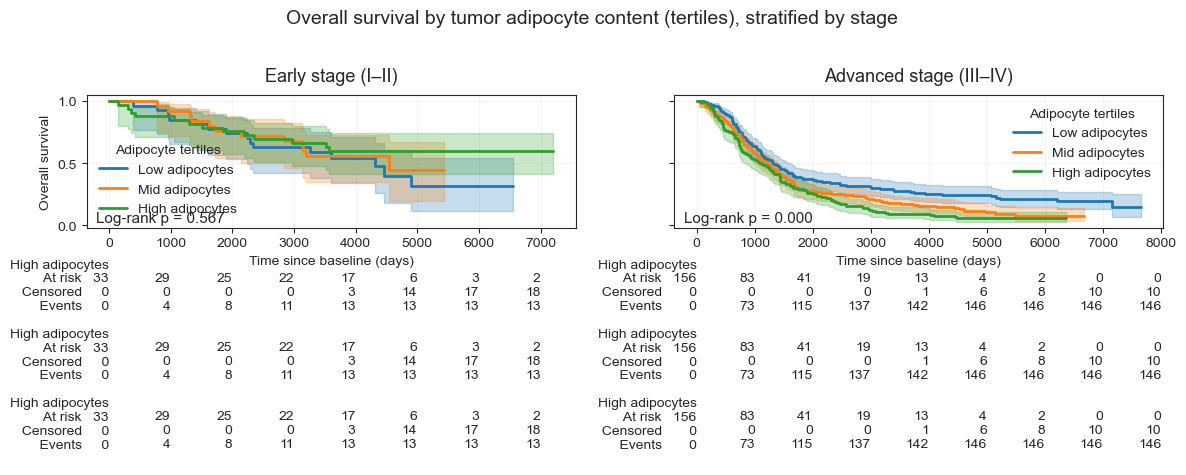

In [35]:
# ===== KM curves by adipocyte tertiles, stratified by Stage (early vs advanced) =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines.plotting import add_at_risk_counts

# ---------- 0) Prep ----------
df = cox_df.copy()

# Keep required columns and drop rows with missing essentials
req = ["Time-Days", "Event", "Adipocytes", "Stage"]
km = df[req].dropna(subset=req).copy()
km["Time-Days"] = km["Time-Days"].astype(float)
km["Event"] = km["Event"].astype(int)

# Ensure Stage is 1/2 (your earlier mapping: 1–2 -> 1, 3–4 -> 2)
# If your df already has Stage in {1,2}, this is a no-op.
km["Stage"] = km["Stage"].astype(int)
stage_name = {1: "Early stage (I–II)", 2: "Advanced stage (III–IV)"}

# ---------- 1) Define adipocyte tertiles (computed globally for balance) ----------
q = np.quantile(km["Adipocytes"], [1 / 3, 2 / 3])
km["AdipoGroup"] = pd.cut(
    km["Adipocytes"],
    bins=[-np.inf, q[0], q[1], np.inf],
    labels=["Low adipocytes", "Mid adipocytes", "High adipocytes"],
)

# Safety: ensure every patient is assigned
assert km["AdipoGroup"].notna().all(), "Some rows did not get a tertile label."


# ---------- 2) Summary tables ----------
def km_summary(tbl):
    # N, events, median time by tertile
    out = (
        tbl.groupby("AdipoGroup", observed=True)
        .apply(
            lambda g: pd.Series(
                {
                    "N": len(g),
                    "Events": int(g["Event"].sum()),
                    "Median_time_days": float(
                        KaplanMeierFitter()
                        .fit(g["Time-Days"], g["Event"])
                        .median_survival_time_
                    ),
                }
            )
        )
        .reset_index()
    )
    return out


sum_all = km_summary(km).assign(Stage="All")
sum_s1 = km_summary(km[km["Stage"] == 1]).assign(Stage=stage_name[1])
sum_s2 = km_summary(km[km["Stage"] == 2]).assign(Stage=stage_name[2])
summary = pd.concat([sum_all, sum_s1, sum_s2], ignore_index=True)
print("KM summary (saved to km_adipocytes_summary_by_stage.csv):")
print(summary)

# ---------- 3) Plot setup ----------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
kmf = KaplanMeierFitter()

for ax_idx, (stage_val, ax) in enumerate(zip([1, 2], axes)):
    sub = km[km["Stage"] == stage_val].copy()
    ax.set_title(stage_name[stage_val], fontsize=13, pad=10)

    # Fit & plot each tertile
    kmfs_for_risk = []
    for label in ["Low adipocytes", "Mid adipocytes", "High adipocytes"]:
        g = sub[sub["AdipoGroup"] == label]
        if len(g) == 0:
            continue
        kmf.fit(g["Time-Days"], g["Event"], label=label)
        kmf.plot(ax=ax, ci_show=True, linewidth=2)
        kmfs_for_risk.append(kmf)

    # Ax cosmetics
    ax.set_xlabel("Time since baseline (days)")
    if ax_idx == 0:
        ax.set_ylabel("Overall survival")
    ax.grid(alpha=0.2)
    ax.legend(title="Adipocyte tertiles", frameon=False, loc="best")

    # At-risk counts under each panel
    if kmfs_for_risk:
        add_at_risk_counts(*kmfs_for_risk, ax=ax)

    # Stage-specific log-rank p-value
    if sub["AdipoGroup"].nunique() >= 2:
        lr = multivariate_logrank_test(
            event_durations=sub["Time-Days"],
            groups=sub["AdipoGroup"],
            event_observed=sub["Event"],
        )
        p = lr.p_value
        ax.text(
            0.02, 0.04, f"Log-rank p = {p:.3f}", transform=ax.transAxes, fontsize=11
        )

# Global figure title + tight layout
fig.suptitle(
    "Overall survival by tumor adipocyte content (tertiles), stratified by stage",
    y=1.02,
    fontsize=14,
)
plt.tight_layout()
plt.show()

In [36]:
# cox_df_both = {}
# cox_df_both["low"] = cox_df[cox_df["Time-Days"] <= cox_df["Time-Days"].median()].copy()

# cox_df_both["high"] = cox_df[cox_df["Time-Days"] >= cox_df["Time-Days"].median()].copy()

In [37]:
# # ------------------------------ fit penalised CoxPH ------------------------------
# cph_both = {}
# for type in cox_df_both:

#     cph_both[type] = CoxPHFitter()

#     cph_both[type].fit(
#         cox_df_both[type],
#         show_progress=True,
#         strata="Stage",
#         duration_col="Time-Days",
#         event_col="Event",
#     )

#     cph_both[type].print_summary(columns=["coef", "exp(coef)", "p", "z"])

#     cph_both[type].plot()

In [38]:
# for mod in cph_both:
#     print(f"Checking assumptions for {mod} time model")
#     cph_both[mod].check_assumptions(cox_df_both[mod], p_value_threshold=0.05, show_plots=True)

## And now 3 models:

In [39]:
# q1 = cox_df["Time-Days"].quantile(1/3)
# q2 = cox_df["Time-Days"].quantile(2/3)

# cox_df_both = {}
# cox_df_both["low"]  = cox_df[cox_df["Time-Days"] <= q1].copy()
# cox_df_both["mid"]  = cox_df[(cox_df["Time-Days"] > q1) & (cox_df["Time-Days"] < q2)].copy()
# cox_df_both["high"] = cox_df[cox_df["Time-Days"] >= q2].copy()

In [40]:
# # ------------------------------ fit penalised CoxPH ------------------------------
# cph_both = {}
# for type in cox_df_both:

#     cph_both[type] = CoxPHFitter()

#     cph_both[type].fit(
#         cox_df_both[type],
#         show_progress=True,
#         strata="Stage",
#         duration_col="Time-Days",
#         event_col="Event",
#     )

#     cph_both[type].print_summary(columns=["coef", "exp(coef)", "p", "z"])

#     cph_both[type].plot()

In [41]:
# for mod in cph_both:
#     print(f"Checking assumptions for {mod} time model")
#     cph_both[mod].check_assumptions(cox_df_both[mod], p_value_threshold=0.05, show_plots=False)

In [42]:
# for mod in cph_both:
#     # ------------------------------------------------------------------
#     # 1. Pull the numbers we need, in a versiofn-agnostic way
#     # ------------------------------------------------------------------
#     sns.set_style("ticks", {"xtick.major.size": 5, "ytick.major.size": 5})
#     summ = cph_both[mod].summary.loc[desired_order].copy()

#     # locate the 95 % CI columns no matter what lifelines called them
#     ci_lower_col = [c for c in summ.columns if c.startswith("coef lower")][0]
#     ci_upper_col = [c for c in summ.columns if c.startswith("coef upper")][0]

#     summ["HR"] = np.exp(summ["coef"])
#     summ["lower95"] = np.exp(summ[ci_lower_col])
#     summ["upper95"] = np.exp(summ[ci_upper_col])
#     # ------------------------------------------------------------------
#     # 2. Plot on a *linear* x-axis
#     # ------------------------------------------------------------------
#     fig, ax = plt.subplots(figsize=(15, 1.5 * len(summ)))
#     ypos = np.arange(len(summ))

#     ax.errorbar(
#         x=summ["HR"],
#         y=ypos,
#         xerr=[summ["HR"] - summ["lower95"], summ["upper95"] - summ["HR"]],
#         fmt="o",
#         capsize=10,
#         linewidth=4.5,
#         elinewidth=4.5,
#         capthick=4.5,
#         markersize=12,
#     )
#     ax.axvline(1, ls="--", lw=1)
#     # mark p < 0.05 covariates with a BIG star
#     for i, p in enumerate(summ["p"]):
#         if p < 0.05:
#             ax.text(
#                 summ["upper95"].iloc[i] * 1.001,
#                 ypos[i],
#                 "*",
#                 va="center",
#                 fontsize=50,
#                 color="red",
#             )
#         if p < 0.005:
#             ax.text(
#                 summ["upper95"].iloc[i] * 1.001,
#                 ypos[i],
#                 "**",
#                 va="center",
#                 fontsize=50,
#                 color="red",
#             )
#         if p < 0.0005:
#             ax.text(
#                 summ["upper95"].iloc[i] * 1.001,
#                 ypos[i],
#                 "***",
#                 va="center",
#                 fontsize=50,
#                 color="red",
#             )
#     padding = 0.5
#     ax.set_ylim(-padding, len(summ) - 1 + padding)
#     ax.set_xscale("log")
#     ax.set_yticks(ypos)
#     ax.set_yticklabels(summ.index, fontsize=35)
#     plt.xticks(fontsize=25)
#     ax.set_ylabel("", fontsize=35)
#     ax.set_xlabel("Hazard Ratio (log scale)", fontsize=35, fontweight="bold")
#     ax.set_title(f"Survival: {mod}", fontsize=45, fontweight="bold", y=1.01, x=0.4)
#     ax.invert_yaxis()  # top row at the top
#     plt.tight_layout()
#     plt.show()

## Now binning adipocytes

Iteration 1: norm_delta = 2.82e+00, step_size = 0.9500, log_lik = -2433.79148, newton_decrement = 5.61e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.12e+00, step_size = 0.9500, log_lik = -1973.75590, newton_decrement = 1.21e+02, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.89e-01, step_size = 0.9500, log_lik = -1837.34888, newton_decrement = 1.31e+01, seconds_since_start = 0.1
Iteration 4: norm_delta = 1.14e-01, step_size = 1.0000, log_lik = -1823.48668, newton_decrement = 3.58e-01, seconds_since_start = 0.1
Iteration 5: norm_delta = 2.38e-03, step_size = 1.0000, log_lik = -1823.12395, newton_decrement = 1.63e-04, seconds_since_start = 0.1
Iteration 6: norm_delta = 1.03e-06, step_size = 1.0000, log_lik = -1823.12379, newton_decrement = 3.57e-11, seconds_since_start = 0.2
Convergence completed after 6 iterations.
                                 Label        HR    CI_low   CI_high
0   Time-varying @ 3 years (per +10pp)  1.131574  0.915015  1.399386
1   Time-varying

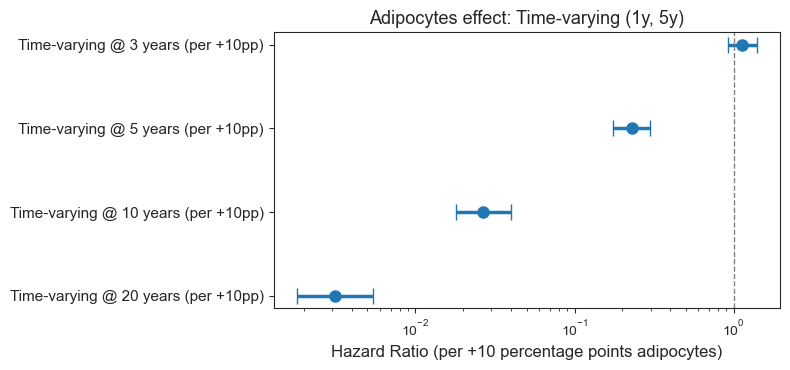

In [43]:
# ===== Forest plot: Standard Cox vs Time-varying HR at 1y and 5y =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, CoxTimeVaryingFitter

# ----------------------------
# 0) Prep
# ----------------------------
df = cox_df.copy()

# ----------------------------
# 2) Time-varying Cox
#     - build (start, stop] data with 1 interval per subject
#     - center log-time at 1 year to make the "main" effect interpretable at 1y
#     - interaction ONLY (no standalone log_time in the model)
# ----------------------------
df0 = df.reset_index(drop=False).rename(columns={"index": "ID"})
if "ID" not in df0.columns:
    df0["ID"] = np.arange(len(df0))

tv = df0.rename(columns={"Time-Days": "stop"}).copy()
tv["start"] = 0.0
## Compute log(time) and subtract log(365) so that at 1 year the transformed time = 0.
t0_days = 1095.0  # 3-year reference
tv["log_time_c"] = np.log(tv["stop"]) - np.log(t0_days)
tv["Adipocytes_time"] = tv["Adipocytes"] * tv["log_time_c"]
tv["log_time_c"] = np.log(np.clip(tv["stop"].astype(float), 1e-8, None)) - np.log(
    t0_days
)
# This means the main Adipocytes coefficient corresponds to the HR at 1 year.
# (Much nicer for interpretation than “at time zero”.)
# IMPORTANT: Adipocytes is ALREADY per +10pp in data. we do NOT rescale.
tv["Adipocytes_time"] = tv["Adipocytes"] * tv["log_time_c"]

ctv = CoxTimeVaryingFitter()
ctv.fit(
    tv[
        [
            "ID",
            "start",
            "stop",
            "Event",
            "Age",
            "BMI",
            "Immune",
            "Stromal",
            "Race: Black",
            "Adipocytes",  # per +10pp, as-is
            "Adipocytes_time",  # time interaction (log-time centered at 1y)
            "Stage",  # used for strata
        ]
    ],
    id_col="ID",
    start_col="start",
    stop_col="stop",
    event_col="Event",
    strata=["Stage"],
    show_progress=True,
)

# ----------------------------
# 3) Compute TV HR at 1 year and 5 years with 95% CIs
#     For a linear predictor L(t) = b_main + k*b_time, where k = log(t) - log(t0),
#     Var(L) = V11 + 2*k*V12 + k^2*V22  (from the covariance matrix)
# ----------------------------
# --- robust name lookup via positions ---
names = ctv.params_.index.to_list()


def get_pos(name, names):
    try:
        return names.index(name)
    except ValueError:
        # help debug quickly if naming differs
        raise KeyError(f"Parameter '{name}' not found. Available names:\n{names}")


i_main = get_pos("Adipocytes", names)
i_time = get_pos("Adipocytes_time", names)

b_main = float(ctv.params_.iloc[i_main])
b_time = float(ctv.params_.iloc[i_time])

Sigma = ctv.variance_matrix_.to_numpy()
V11 = float(Sigma[i_main, i_main])
V22 = float(Sigma[i_time, i_time])
V12 = float(Sigma[i_main, i_time])


def hr_ci_at_time(days):
    k = np.log(days) - np.log(t0_days)
    mu = b_main + k * b_time
    var = V11 + 2.0 * k * V12 + (k**2) * V22
    se = np.sqrt(max(var, 0.0))  # guard for tiny negatives from numerics
    lo = mu - 1.96 * se
    hi = mu + 1.96 * se
    return np.exp(mu), np.exp(lo), np.exp(hi)


hr_3y, lo_3y, hi_3y = hr_ci_at_time(1090.0)  # at 1 year
hr_5y, lo_5y, hi_5y = hr_ci_at_time(1825.0)  # at 5 years
hr_10y, lo_10y, hi_10y = hr_ci_at_time(3650.0)  # at 10 years
hr_20y, lo_20y, hi_20y = hr_ci_at_time(7300.0)  # at 20 years


# ----------------------------
# 4) Combine into one table for plotting
# ----------------------------
rows = [
    ("Time-varying @ 3 years (per +10pp)", hr_3y, lo_3y, hi_3y),
    ("Time-varying @ 5 years (per +10pp)", hr_5y, lo_5y, hi_5y),
    ("Time-varying @ 10 years (per +10pp)", hr_10y, lo_10y, hi_10y),
    ("Time-varying @ 20 years (per +10pp)", hr_20y, lo_20y, hi_20y),
]
forest_df = pd.DataFrame(rows, columns=["Label", "HR", "CI_low", "CI_high"])
print(forest_df)

# ----------------------------
# 5) Forest plot
# ----------------------------
fig, ax = plt.subplots(figsize=(8, 3.8))

ypos = np.arange(len(forest_df))[::-1]  # top to bottom
ax.errorbar(
    x=forest_df["HR"].values,
    y=ypos,
    xerr=[
        forest_df["HR"].values - forest_df["CI_low"].values,
        forest_df["CI_high"].values - forest_df["HR"].values,
    ],
    fmt="o",
    capsize=6,
    elinewidth=2.5,
    markersize=8,
)
ax.axvline(1.0, ls="--", lw=1, color="grey")

ax.set_yticks(ypos)
ax.set_yticklabels(forest_df["Label"].values, fontsize=11)
ax.set_xlabel("Hazard Ratio (per +10 percentage points adipocytes)", fontsize=12)
ax.set_xscale("log")
ax.set_title("Adipocytes effect: Time-varying (1y, 5y)", fontsize=13)
plt.tight_layout()
plt.show()

In [44]:
# coefficients and cov matrix
print(ctv.summary.loc[["Adipocytes", "Adipocytes_time"], ["coef", "se(coef)", "p"]])

# direct 1-year HR from coef
hr1_direct = np.exp(ctv.params_.loc["Adipocytes"])
print("Direct HR at 1y:", hr1_direct)

                     coef  se(coef)              p
covariate                                         
Adipocytes       0.109431  0.108496   3.131603e-01
Adipocytes_time -3.098096  0.126194  4.297901e-133
Direct HR at 1y: 1.115642566408581


In [45]:
b = float(ctv.params_.loc["Adipocytes"])
print("HR per +10pp at 1y:", np.exp(b))
print("HR per  +1pp at 1y:", np.exp(b / 10))

HR per +10pp at 1y: 1.115642566408581
HR per  +1pp at 1y: 1.0110031473772028


In [46]:
def hr_at_time_by_contrast(t_days):
    k = np.log(t_days) - np.log(365.0)
    b_main = float(ctv.params_.loc["Adipocytes"])
    b_time = float(ctv.params_.loc["Adipocytes_time"])
    # linear predictor difference for +1 “unit” (= +10pp)
    dLP = b_main + k * b_time
    return np.exp(dLP)


print("Contrast HR at 1y:", hr_at_time_by_contrast(365.0))
print("Contrast HR at 3y:", hr_at_time_by_contrast(1090.0))
print("Contrast HR at 5y:", hr_at_time_by_contrast(1825.0))

Contrast HR at 1y: 1.115642566408581
Contrast HR at 3y: 0.037628358743983376
Contrast HR at 5y: 0.007621643322357354


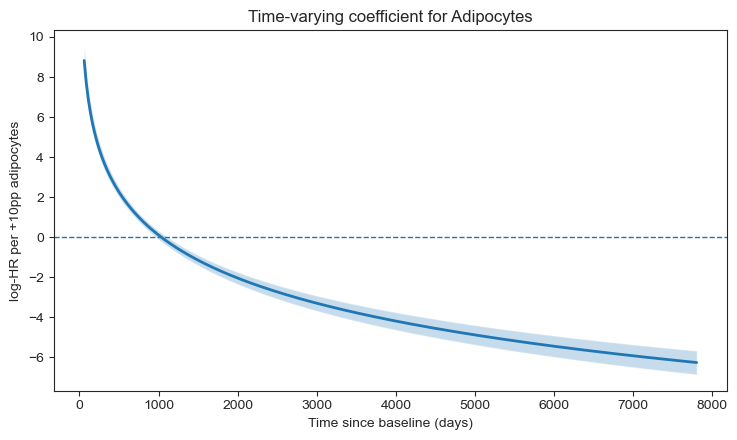

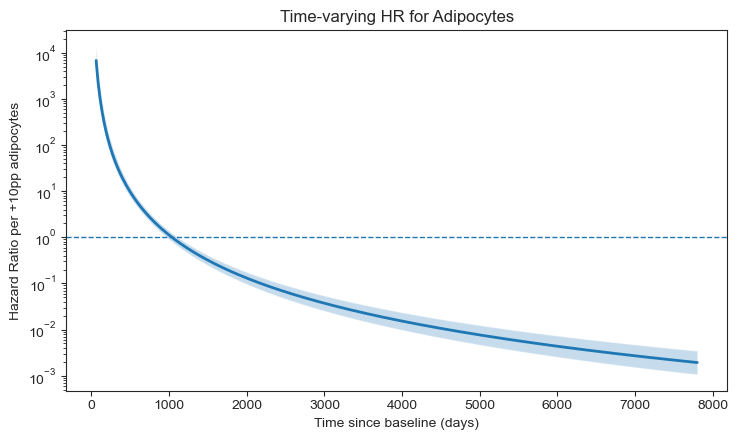

In [47]:
# ===== Plot time-varying coefficient and HR for Adipocytes =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_timevarying_coef_and_hr(
    ctv,
    main_name="Adipocytes",  # coefficient name for the main adipocyte effect
    time_name="Adipocytes_time",  # coefficient name for the interaction term
    t0_days=365.0,  # reference time used for centering log-time
    t_min_days=60.0,  # lower bound for plotting window
    t_max_days=3650.0,  # upper bound (e.g., 10 years)
    n_points=200,  # grid resolution
    show_hr=True,  # also plot HR(t) with CI
):
    """
    Plots the time-varying coefficient beta_A(t) = beta_A + (log(t)-log(t0))*beta_{A,t}
    and optionally the corresponding HR(t) = exp(beta_A(t)), with 95% CIs via the delta method.
    Assumes ctv is a fitted lifelines.CoxTimeVaryingFitter with parameters [main_name, time_name].
    """

    # --- 1) pull parameters and 2x2 covariance block ---
    names = ctv.params_.index.to_list()
    try:
        i_main = names.index(main_name)
        i_time = names.index(time_name)
    except ValueError as e:
        raise KeyError(
            f"Couldn't find {e} in model coefficients. Available names:\n{names}"
        )

    b_main = float(ctv.params_.iloc[i_main])
    b_time = float(ctv.params_.iloc[i_time])

    Sigma = ctv.variance_matrix_.to_numpy()
    V11 = float(Sigma[i_main, i_main])
    V22 = float(Sigma[i_time, i_time])
    V12 = float(Sigma[i_main, i_time])

    # --- 2) build time grid and compute beta(t) and CI on log scale ---
    t_grid = np.linspace(t_min_days, t_max_days, n_points)
    k = np.log(t_grid) - np.log(t0_days)

    mu = b_main + k * b_time  # log-HR(t) per +10pp
    var = V11 + 2.0 * k * V12 + (k**2) * V22
    var = np.maximum(var, 0.0)  # guard against tiny negatives
    se = np.sqrt(var)
    lo = mu - 1.96 * se
    hi = mu + 1.96 * se

    # --- 3) Plot coefficient curve beta(t) with 95% CI ---
    fig1, ax1 = plt.subplots(figsize=(7.5, 4.5))
    ax1.plot(t_grid, mu, linewidth=2)
    ax1.fill_between(t_grid, lo, hi, alpha=0.25)
    ax1.axhline(0.0, ls="--", lw=1)
    ax1.set_xlabel("Time since baseline (days)")
    ax1.set_ylabel(r"log-HR per +10pp adipocytes")
    ax1.set_title("Time-varying coefficient for Adipocytes")
    plt.tight_layout()
    plt.show()

    # --- 4) Plot HR(t) with 95% CI on log x-axis or linear? (use linear x, log y) ---
    if show_hr:
        HR = np.exp(mu)
        HR_lo = np.exp(lo)
        HR_hi = np.exp(hi)

        fig2, ax2 = plt.subplots(figsize=(7.5, 4.5))
        ax2.plot(t_grid, HR, linewidth=2)
        ax2.fill_between(t_grid, HR_lo, HR_hi, alpha=0.25)
        ax2.axhline(1.0, ls="--", lw=1)
        ax2.set_xlabel("Time since baseline (days)")
        ax2.set_ylabel("Hazard Ratio per +10pp adipocytes")
        ax2.set_yscale("log")  # HRs are multiplicative; log scale is easier to read
        ax2.set_title("Time-varying HR for Adipocytes")
        plt.tight_layout()
        plt.show()


# ---- call it (uses your fitted `ctv`) ----
plot_timevarying_coef_and_hr(
    ctv,
    main_name="Adipocytes",
    time_name="Adipocytes_time",
    t0_days=1000.0,  # matches your centering
    t_min_days=60.0,  # adjust if you want to start later/earlier
    t_max_days=7800.0,  # ~10 years
    n_points=300,
    show_hr=True,
)